In [1]:
import numpy as np
import pandas as pd
import gget
import glob
import networkx as nx
import os
import seaborn as sns
import gget
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import zscore
import scipy

# Load sc data

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/analysis.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]
adata

AnnData object with n_obs × n_vars = 8563 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str', 'UMAP 1', 'UMAP 2'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

# Load isoforms

In [30]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/isoforms/isoform_data.parquet"

df = pd.read_parquet(fpath)
df = df[df['cell_id'].isin(adata.obs_names)] # filter out undetected CBs

# add nulti-map flag
df['n_isoforms'] = df.groupby('gene_name')['transcript_name'].transform('nunique')

print(f"{df.shape=}")
df = pd.merge(
    df, 
    adata.obs,
    how='left',
    left_on='cell_id',
    right_index=True,
)

outpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/isoforms/isoquant.parquet"
df.to_parquet(outpath, index=False)
df.head()

df.shape=(11373142, 9)


,isoform_id,gene_id,run_id,cell_id,UMI,read_name,gene_name,transcript_name,n_isoforms,n_genes,...,pct_counts_mt,EC_score,EB_score,FB_score,HSC_score,MK_score,new_cluster,cluster_str,UMAP 1,UMAP 2
0,ENST00000483767,ENSG00000188976,Run3x0418,TGTGGCGGTAACGGTG,AAGTTTACCGGG,b43c7b93-2130-42e0-a51d-2819bedeb593,NOC2L,NOC2L-204,5,3240,...,0.0,-0.379568,-0.123400,0.011569,1.018077,0.625096,2,C3,10.377001,0.175446
1,ENST00000483767,ENSG00000188976,Run3x0418,CTAACTTGTCGTCATA,TTTTGGATCTTT,5887c2fa-b3bd-4a22-b3f8-4ce31b4e9d0d,NOC2L,NOC2L-204,5,2759,...,0.0,0.051541,-0.289844,2.223045,0.062807,1.888035,0,C1,30.267242,19.801859
2,ENST00000483767,ENSG00000188976,Run3x0418,AAGATAGAGTTGGGAC,AACGGGTCCTCT,050743c4-d895-45d6-b59a-c5232b6ac1b1,NOC2L,NOC2L-204,5,2086,...,0.0,0.277122,-1.179204,0.089226,-0.847041,-0.094821,2,C3,5.467855,-1.994860
3,ENST00000469563,ENSG00000188976,Run3x0418,TATACCTAGTCGGCCT,AACGGTTAGCCG,f24c150f-2a5a-4581-96a7-081d004d28c6,NOC2L,NOC2L-202,5,1767,...,0.0,0.348476,-0.765833,-0.331774,-0.293442,-0.303122,2,C3,6.937809,5.550777
4,ENST00000469563,ENSG00000188976,Run3x0418,TGTAAGCGTGTCATTG,AAACTCTAACTT,166e19dc-cd7c-4ee2-b35e-eb3ceb455285,NOC2L,NOC2L-202,5,1702,...,0.0,0.964298,0.312818,-0.058170,-0.854960,-1.300806,0,C1,15.603737,18.653664


# Plot some

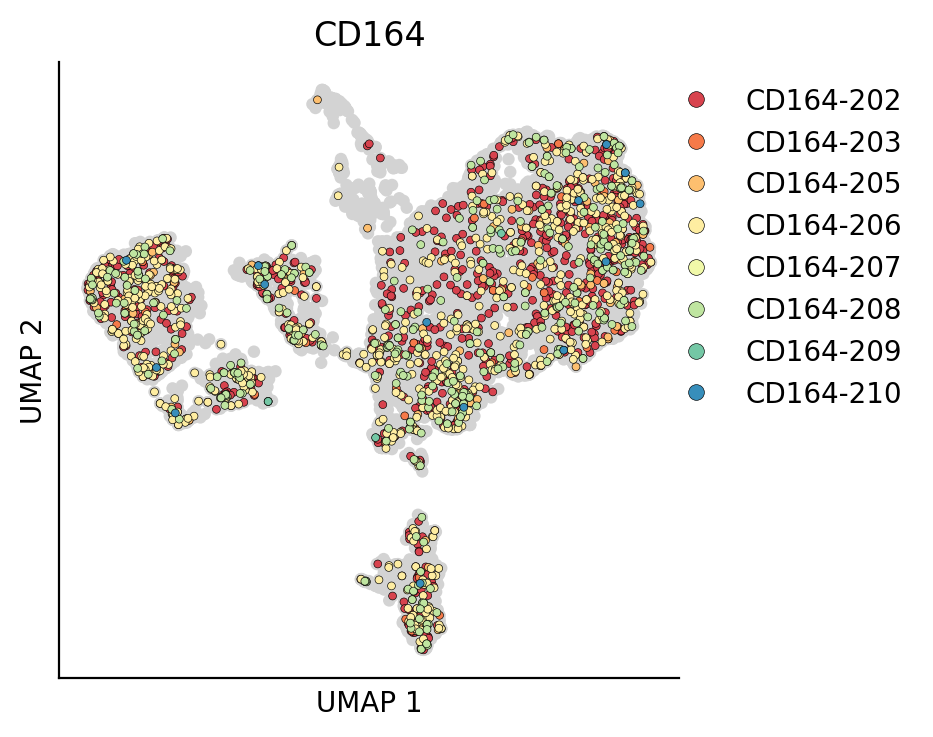

In [4]:
def plot_isoform_umap(adata, df, query, size=15, palette='Spectral'):
    """
    Plots UMAP visualization of gene expression for a given query gene, with customizable parameters.

    Args:
        adata: AnnData object containing the expression data and UMAP coordinates.
        df: DataFrame containing gene annotations (gene_name, transcript_name, etc.).
        query: String representing the query gene name.
        size: Integer controlling the size of the scatterplot markers.
        palette: String or list specifying the color palette for the transcript_name hue.
    """

    pdf = adata.obs.copy()
    pdf = pdf.reset_index()

    query_df = df[df['gene_name'] == query]
    
    if query_df.empty:
        return

    pdf = pd.merge(pdf, query_df, how='left')
    pdf = pdf.sort_values(by='transcript_name')
    pdf['transcript_name'] = pdf['transcript_name'].astype(str)
    mask = pdf['transcript_name'] != 'nan'

    sns.scatterplot(
        data=pdf,
        x='UMAP 1',
        y='UMAP 2',
        color='lightgrey',
        zorder=0,
        ec='none',
        s=size,
    )

    sns.scatterplot(
        data=pdf[mask],
        x='UMAP 1',
        y='UMAP 2',
        hue='transcript_name',
        ec='k',
        s=size / 2.5,
        palette=palette,
    )

    plt.xticks([])
    plt.yticks([])

    plt.ylabel('UMAP 2')
    plt.xlabel('UMAP 1')

    sns.despine()

    plt.title(query)
    plt.gca().set_aspect('auto')

    sns.move_legend(
        plt.gca(),
        loc='upper right',
        title="",
        frameon=False,
        bbox_to_anchor=(1.4, 1),
        markerscale=2,
    )
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4
plot_isoform_umap(adata, df, query='CD164', size=20)

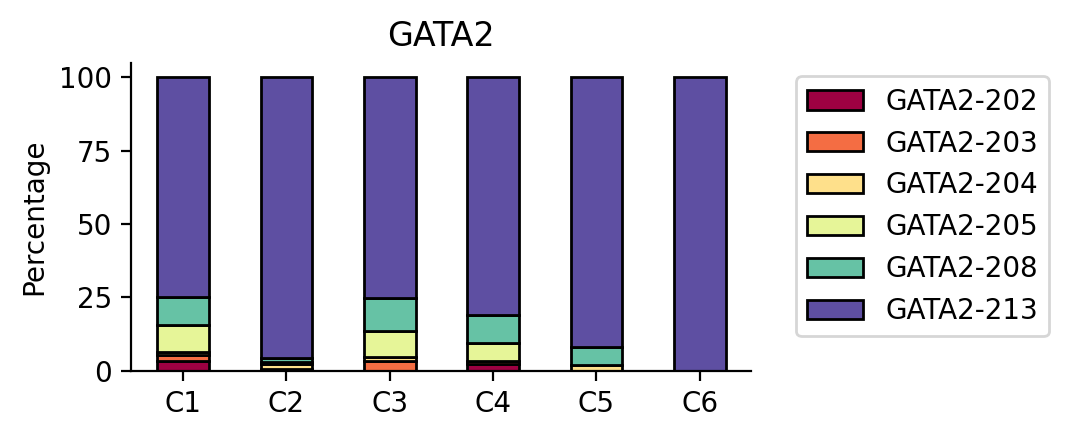

In [5]:
def plot_cluster_expression(adata, df, query, palette='Spectral'):
    """
    Plots stacked bar charts showing the percentage of each cluster expressing each transcript for a given query gene.

    Args:
        adata: AnnData object containing the expression data and UMAP coordinates.
        df: DataFrame containing gene annotations (gene_name, transcript_name, etc.).
        query: String representing the query gene name.
        palette: String or list specifying the color palette for the transcript_name hue.
    """

    pdf = adata.obs.copy()
    pdf = pdf.reset_index()

    query_df = df[df['gene_name'] == query]

    if query_df.empty:
        return

    pdf = pd.merge(pdf, query_df, how='left')
    pdf = pdf.sort_values(by='transcript_name')

    # Group by cluster and transcript, count the number of cells expressing each transcript
    expression_counts = pdf.groupby(['cluster_str', 'transcript_name'], 
                                    observed=True).size().unstack(fill_value=0)

    # Calculate the percentage of cells expressing each transcript within each cluster
    percentage_expression = expression_counts.div(expression_counts.sum(axis=1), axis=0) * 100

    # Plot stacked bar charts
    percentage_expression.plot(
        kind='bar',
        stacked=True,
        colormap=palette,
        ec="k",
    )
    plt.xlabel('')
    plt.ylabel('Percentage')
    plt.title(f'{query}')
    plt.gca().tick_params(axis='x', rotation=0)
    sns.despine()
    plt.legend(
        title='', 
        bbox_to_anchor=(1.05, 1), 
        loc='upper left')
    
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2
plot_cluster_expression(adata, df, query='GATA2', palette='Spectral')  

In [6]:
mask = (df['cluster_str'] == 'C4') & (df['n_isoforms'] > 1)
df[mask]['transcript_name'].value_counts()

transcript_name
NDUFS5-201      602
RPS15A-203      602
TOMM7-201       602
RPS13-202       602
RPL35-201       602
               ... 
DMWD-204          1
DACT3-201         1
SAE1-212          1
NAPA-215          1
HSD17B14-203      1
Name: count, Length: 39873, dtype: int64

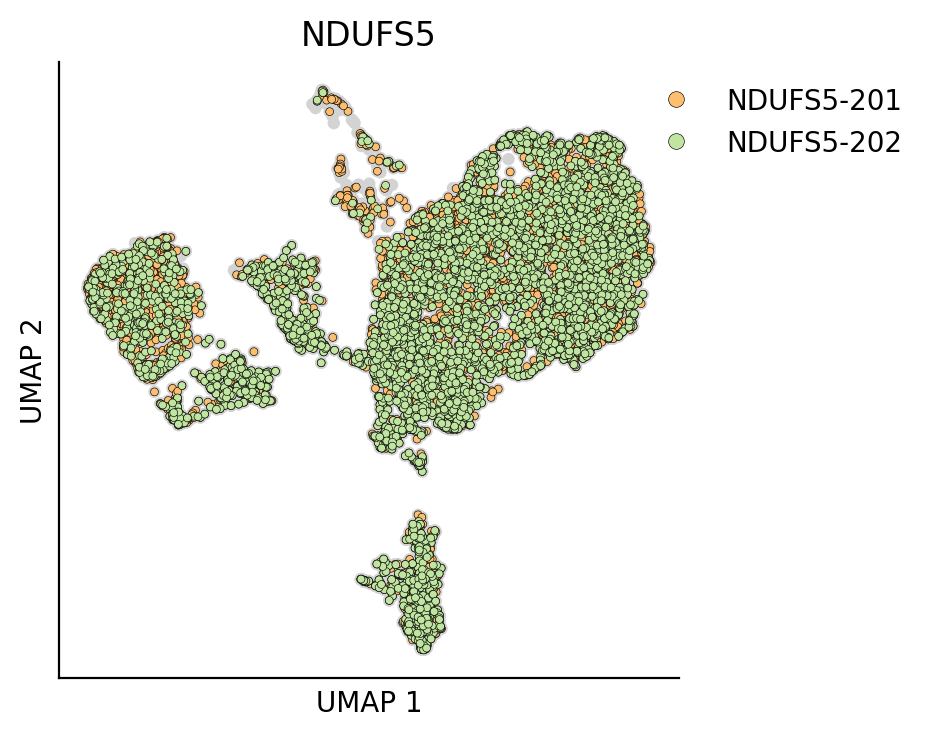

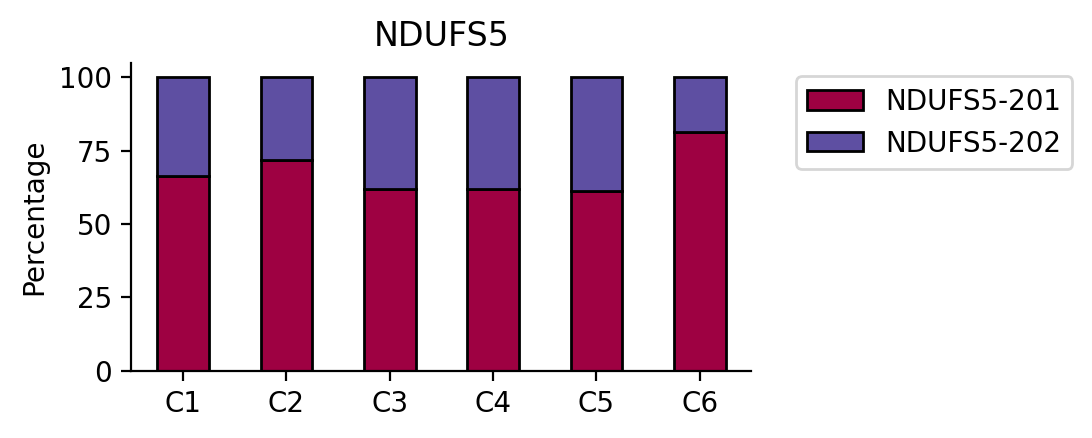

In [7]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

query = 'NDUFS5'

plot_isoform_umap(adata, df, query=query, size=20)
plt.show()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2
plot_cluster_expression(adata, df, query)
plt.show()

n genes: 8


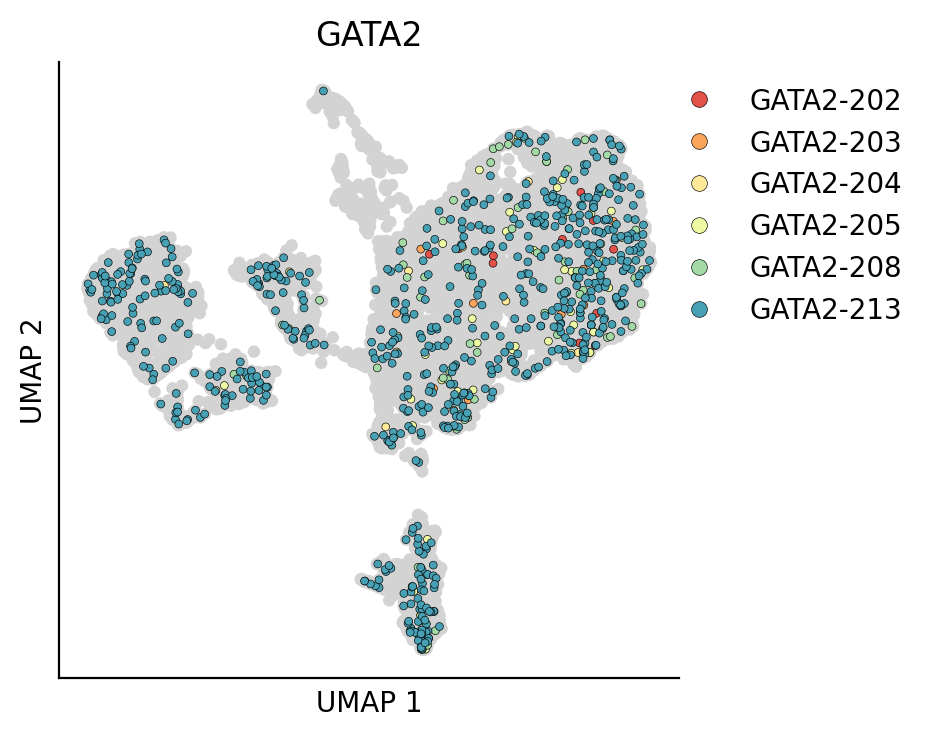

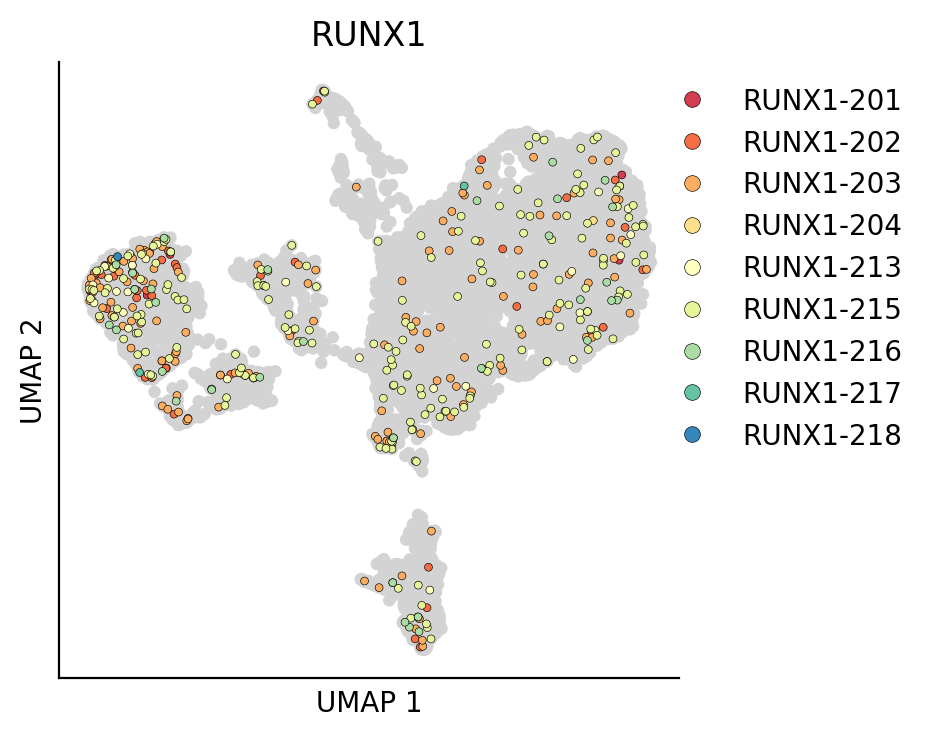

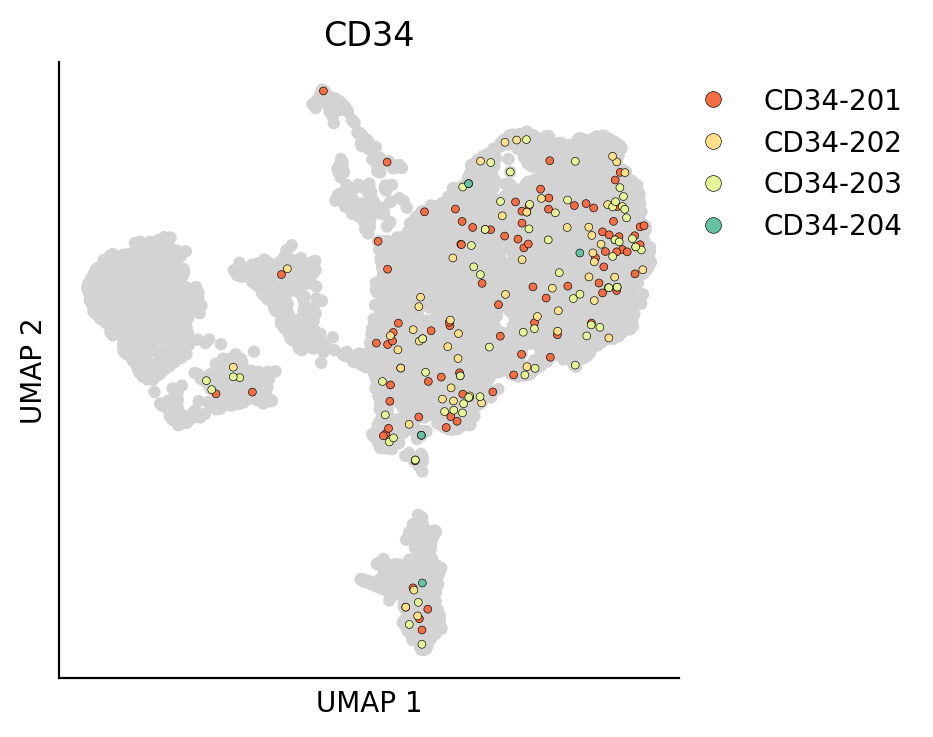

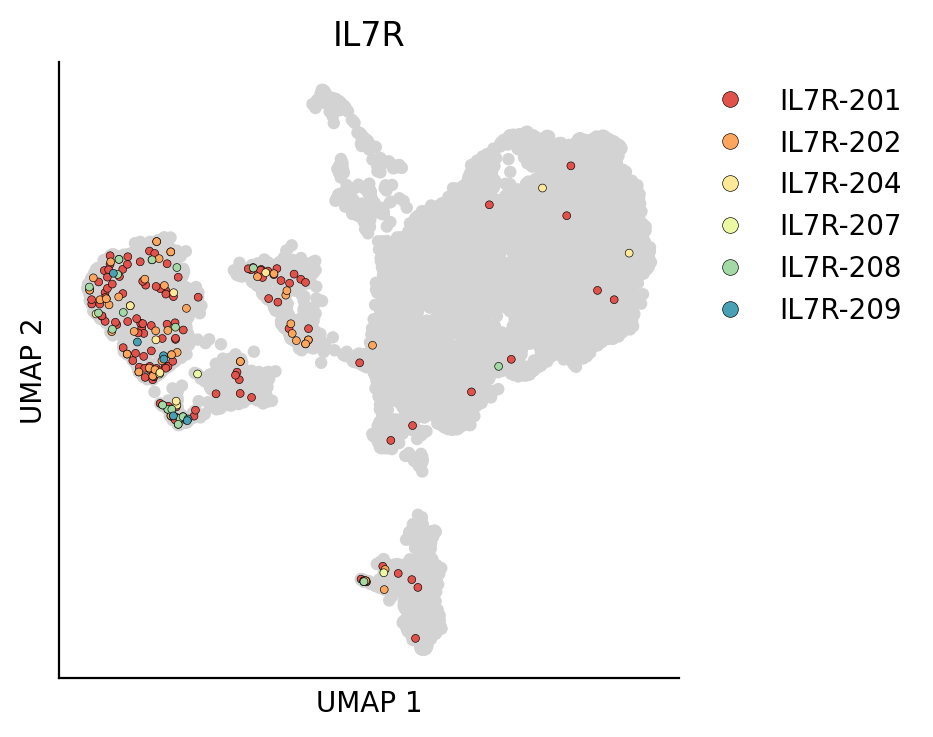

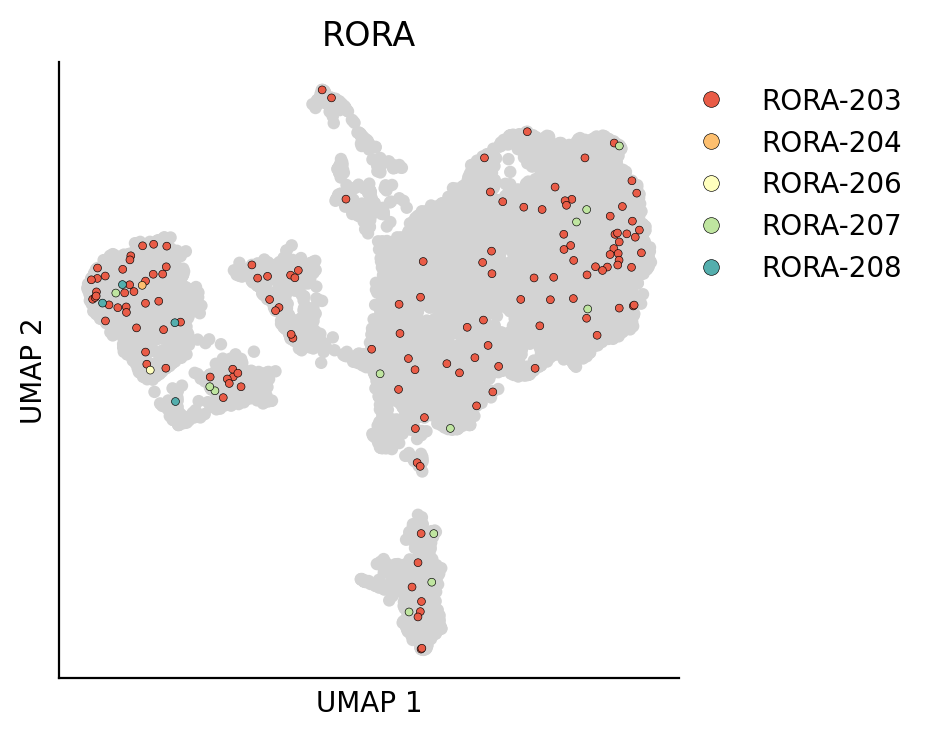

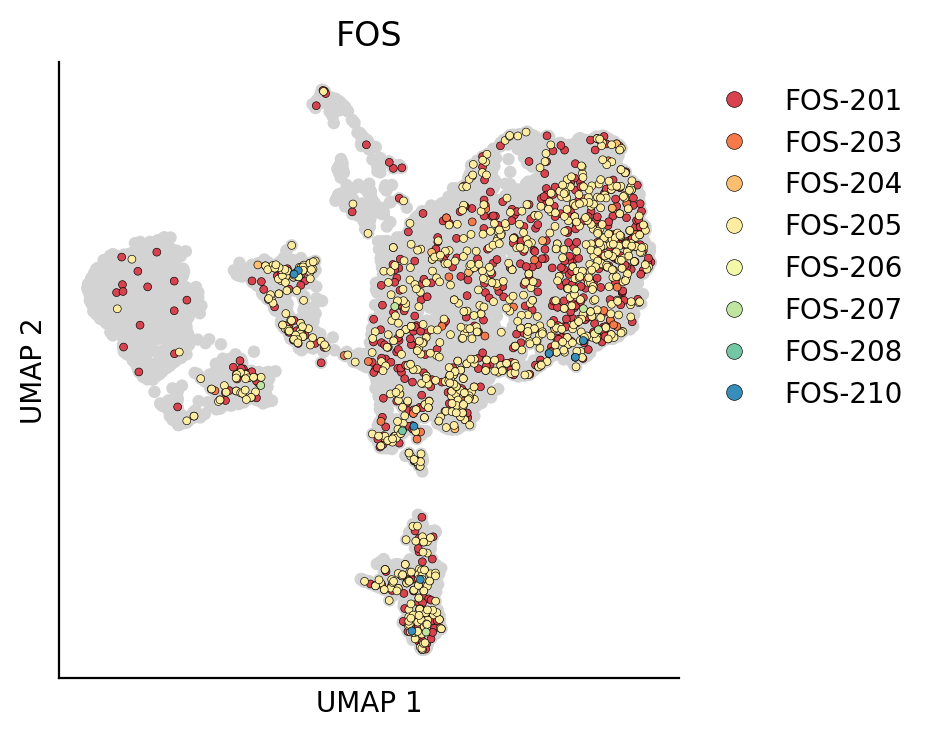

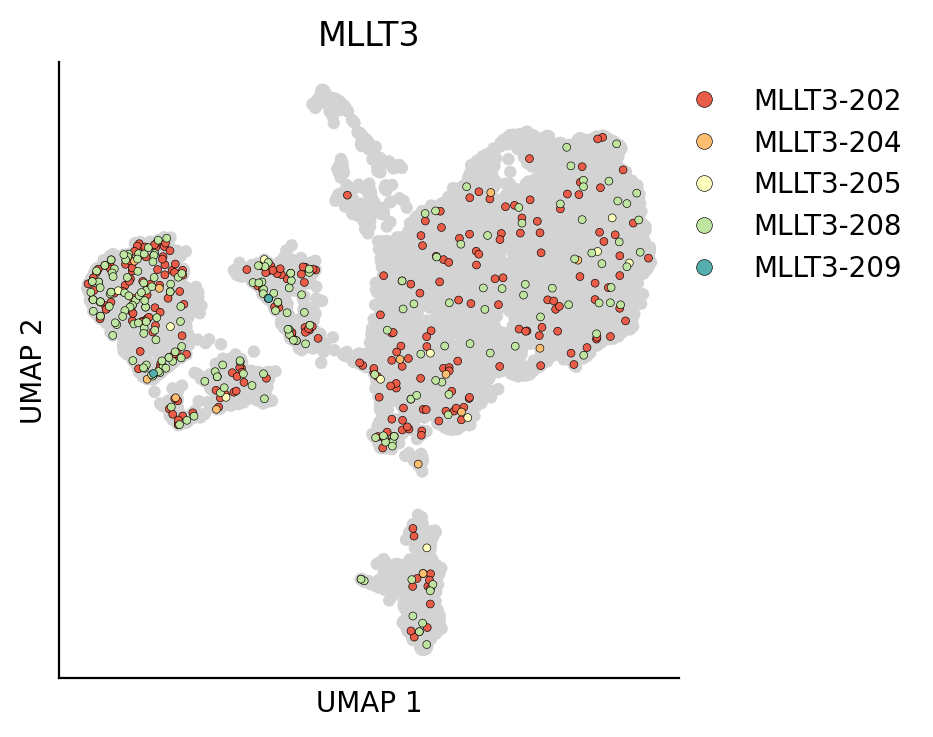

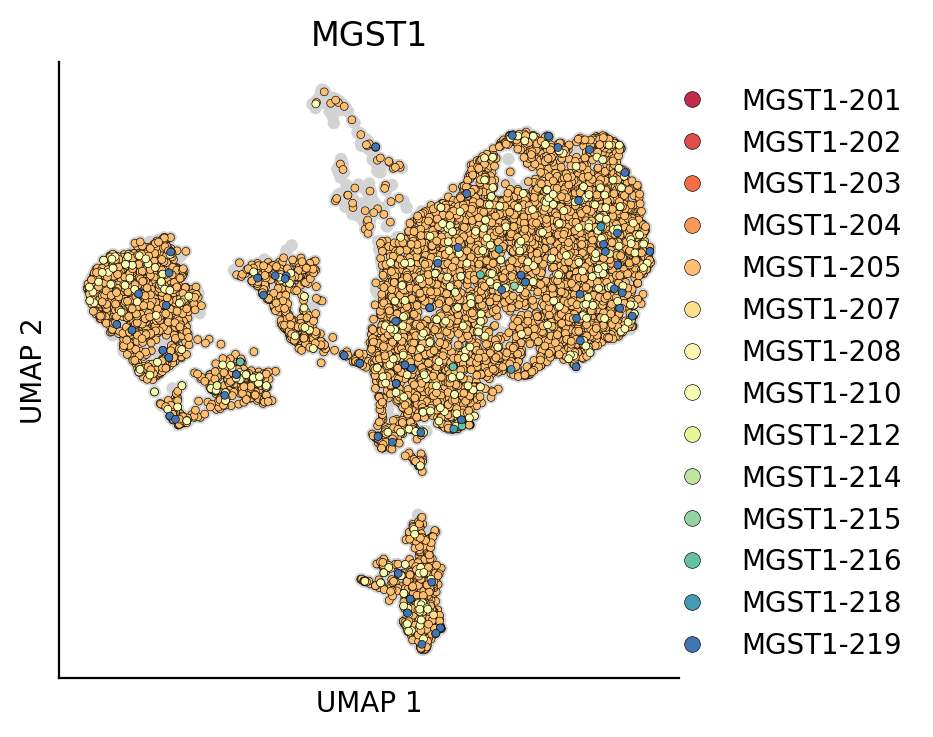

In [8]:
gene_list = [
    'GATA2', 'RUNX1', 'CD34', 'IL7R', 'RORA', 'FOS','MLLT3','MGST1',
]

gene_list = [x for x in gene_list if x in adata.var['gene_name'].values]
print(f"n genes: {len(gene_list)}")

for gene in gene_list:
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 4, 4
    plot_isoform_umap(
        adata, 
        df, 
        query=gene, 
        size=20,
    )
    plt.show()

# Differential ISO Explore

In [9]:
df['value'] = 1
df.head()

,isoform_id,gene_id,run_id,cell_id,UMI,read_name,gene_name,transcript_name,n_isoforms,n_genes,...,EC_score,EB_score,FB_score,HSC_score,MK_score,new_cluster,cluster_str,UMAP 1,UMAP 2,value
0,ENST00000483767,ENSG00000188976,Run3x0418,TGTGGCGGTAACGGTG,AAGTTTACCGGG,b43c7b93-2130-42e0-a51d-2819bedeb593,NOC2L,NOC2L-204,5,3240,...,-0.379568,-0.123400,0.011569,1.018077,0.625096,2,C3,10.377001,0.175446,1
1,ENST00000483767,ENSG00000188976,Run3x0418,CTAACTTGTCGTCATA,TTTTGGATCTTT,5887c2fa-b3bd-4a22-b3f8-4ce31b4e9d0d,NOC2L,NOC2L-204,5,2759,...,0.051541,-0.289844,2.223045,0.062807,1.888035,0,C1,30.267242,19.801859,1
2,ENST00000483767,ENSG00000188976,Run3x0418,AAGATAGAGTTGGGAC,AACGGGTCCTCT,050743c4-d895-45d6-b59a-c5232b6ac1b1,NOC2L,NOC2L-204,5,2086,...,0.277122,-1.179204,0.089226,-0.847041,-0.094821,2,C3,5.467855,-1.994860,1
3,ENST00000469563,ENSG00000188976,Run3x0418,TATACCTAGTCGGCCT,AACGGTTAGCCG,f24c150f-2a5a-4581-96a7-081d004d28c6,NOC2L,NOC2L-202,5,1767,...,0.348476,-0.765833,-0.331774,-0.293442,-0.303122,2,C3,6.937809,5.550777,1
4,ENST00000469563,ENSG00000188976,Run3x0418,TGTAAGCGTGTCATTG,AAACTCTAACTT,166e19dc-cd7c-4ee2-b35e-eb3ceb455285,NOC2L,NOC2L-202,5,1702,...,0.964298,0.312818,-0.058170,-0.854960,-1.300806,0,C1,15.603737,18.653664,1


In [10]:
# create a cell x transcript matrix
X = pd.pivot_table(
    df[df['n_isoforms'] > 1], # only for genes with multiple isoforms 
    index='cell_id',
    columns='transcript_name',
    values='value',
    fill_value=0.0,
)

print(f"{X.shape=}")

# map clusters
group_map = dict(zip(adata.obs.index, adata.obs.cluster_str))

X['cluster'] = X.index.map(group_map)
X.head()

X.shape=(8563, 72316)


transcript_name,A1BG-201,A1BG-202,A1BG-203,A1BG-204,A2M-201,A2M-205,A2M-207,A4GALT-201,A4GALT-202,A4GALT-205,...,ZZEF1-210,ZZZ3-201,ZZZ3-202,ZZZ3-204,ZZZ3-205,ZZZ3-206,ZZZ3-209,ZZZ3-210,ZZZ3-211,cluster
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGGTTACCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C1
AAACCCAAGTTGAAGT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C1
AAACCCAAGTTGTCGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C4
AAACCCACAGAAGCGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C2
AAACCCACAGGAGGTT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C1


In [11]:
# compute proportions and pivot 
prop = X.groupby('cluster').mean().T

# DROP C6
prop = prop.drop(columns=['C6'])

prop['std'] = prop.std(axis=1)
prop = prop.sort_values(by='std', ascending=False)

prop.head(25)

cluster,C1,C2,C3,C4,C5,std
transcript_name,,,,,,
LUM-203,0.048638,0.965753,0.074356,0.101329,0.570470,0.405084
THBS1-201,0.061879,0.910388,0.104215,0.159468,0.749441,0.400697
TNFRSF11B-201,0.042017,0.927511,0.069672,0.046512,0.156600,0.382399
TOP2A-201,0.060351,0.094178,0.042740,0.911960,0.038031,0.382170
UBE2C-204,0.017316,0.050799,0.019906,0.820598,0.020134,0.355157
CKS1B-201,0.101859,0.140982,0.129977,0.855482,0.093960,0.330964
DCN-220,0.017571,0.730023,0.027518,0.049834,0.467562,0.324416
PTTG1-201,0.116119,0.126142,0.148712,0.840532,0.102908,0.321116
DKK1-201,0.046346,0.532534,0.045667,0.122924,0.724832,0.314159


# filter HSC genes

In [12]:
hsc_genes = list(adata.uns['go_annotations']['gene_name'].unique())

hsc_iso = prop[prop.index.str.contains('|'.join(hsc_genes))]
print(f"{hsc_iso.shape=}")
hsc_iso.head(25)

hsc_iso.shape=(492, 6)


cluster,C1,C2,C3,C4,C5,std
transcript_name,,,,,,
FSTL1-201,0.204736,0.488014,0.209602,0.370432,0.563758,0.161612
OCIAD2-205,0.162720,0.063356,0.262295,0.225914,0.143177,0.077102
TMED10-201,0.454036,0.460616,0.423302,0.501661,0.586130,0.062977
OCIAD2-204,0.175452,0.075913,0.245902,0.189369,0.161074,0.061435
CCN3-201,0.001273,0.140982,0.002927,0.006645,0.013423,0.060516
XRCC5-206,0.100076,0.111872,0.128220,0.235880,0.152125,0.054095
MED19-202,0.148714,0.100457,0.203162,0.229236,0.170022,0.049743
MED11-201,0.126560,0.117009,0.161593,0.217608,0.172260,0.040103
RUNX1T1-203,0.002292,0.073630,0.000000,0.001661,0.020134,0.031325


In [13]:
# break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [14]:
prop.sort_values(by='C4', ascending=False).head(10)

cluster,C1,C2,C3,C4,C5,std
transcript_name,,,,,,
TIMP1-201,0.999745,0.996005,0.969555,1.0,0.993289,0.012699
IFITM3-201,0.996944,0.996005,0.964286,1.0,0.997763,0.015006
TOMM7-201,0.993888,0.985160,0.954333,1.0,0.997763,0.018707
RPL35-201,0.998472,0.997146,0.976581,1.0,0.997763,0.009791
RPS10-208,0.998727,0.993721,0.974239,1.0,1.000000,0.010986
RPL7A-202,0.997963,0.989726,0.956674,1.0,1.000000,0.018491
RPL11-201,0.998981,0.994292,0.969555,1.0,1.000000,0.013078
UBA52-201,0.995926,0.990868,0.965457,1.0,1.000000,0.014467
FTH1-201,0.997199,0.987443,0.963700,1.0,0.995526,0.014774


In [15]:
prop.head(25)

cluster,C1,C2,C3,C4,C5,std
transcript_name,,,,,,
LUM-203,0.048638,0.965753,0.074356,0.101329,0.570470,0.405084
THBS1-201,0.061879,0.910388,0.104215,0.159468,0.749441,0.400697
TNFRSF11B-201,0.042017,0.927511,0.069672,0.046512,0.156600,0.382399
TOP2A-201,0.060351,0.094178,0.042740,0.911960,0.038031,0.382170
UBE2C-204,0.017316,0.050799,0.019906,0.820598,0.020134,0.355157
CKS1B-201,0.101859,0.140982,0.129977,0.855482,0.093960,0.330964
DCN-220,0.017571,0.730023,0.027518,0.049834,0.467562,0.324416
PTTG1-201,0.116119,0.126142,0.148712,0.840532,0.102908,0.321116
DKK1-201,0.046346,0.532534,0.045667,0.122924,0.724832,0.314159


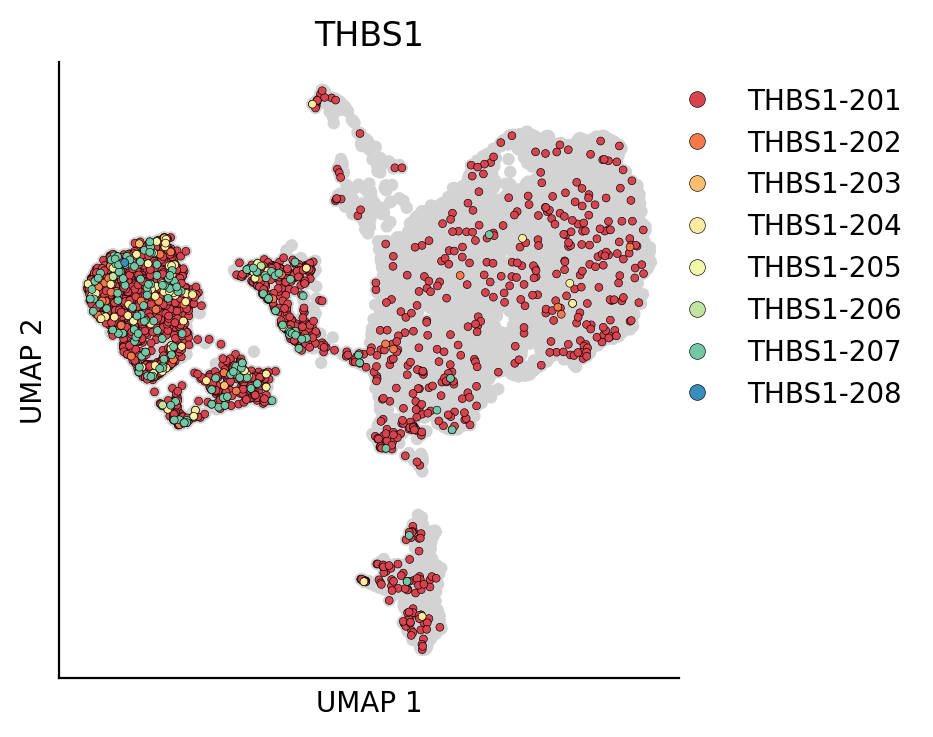

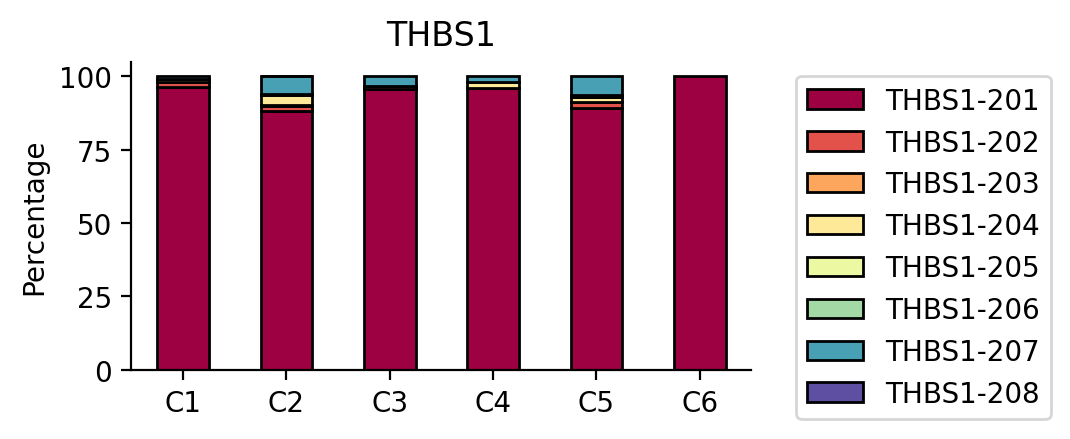

In [29]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

query = 'THBS1'

plot_isoform_umap(adata, df, query=query, size=20)
plt.show()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2
plot_cluster_expression(adata, df, query)
plt.show()

# STDEV enrichments

In [17]:
n_genes = 100
database = 'ontology'
sort_by = 'C2'
prop = prop.sort_values(by=sort_by, ascending=False)
query_genes = list(prop.head(n_genes).index)
query_genes = [x.split("-")[0] for x in query_genes]

edf = gget.enrichr(
    query_genes, 
    database=database,
)

pd.set_option('display.max_colwidth', 150)
edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(10)

Thu Aug 15 16:02:30 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,path_name,adj_p_val,overlapping_genes
0,SRP-dependent cotranslational protein targeting to membrane (GO:0006614),9.369776e-91,"[RPL5, RPL30, RPL3, RPL32, RPLP1, RPL12, RPL11, RPL10A, RPL8, RPS15, RPL7A, RPS17, RPS15A, RPS19, RPS18, RPL36, RPL35, RPLP2, RPL37, SEC61B, RPS2,..."
1,protein targeting to ER (GO:0045047),2.613298e-87,"[RPL5, RPL30, RPL3, RPL32, RPL12, RPLP1, RPL11, RPL10A, RPL8, RPS15, RPL7A, RPS17, RPS15A, RPS19, RPS18, SEC61G, RPL36, RPL35, RPLP2, RPS2, RPL37,..."
2,cotranslational protein targeting to membrane (GO:0006613),2.613298e-87,"[RPL5, RPL30, RPL3, RPL32, RPL12, RPLP1, RPL11, RPL10A, RPL8, RPS15, RPL7A, RPS17, RPS15A, RPS19, RPS18, RPL36, RPL35, RPLP2, RPS2, RPL37, RPL18, ..."
3,cytoplasmic translation (GO:0002181),4.245812e-85,"[RPL5, RPL30, RPL3, RPL32, RPL12, RPLP1, RPL11, RPL10A, RPL8, RPS15, RPL7A, RPS17, RPS15A, RPS19, RPS18, RPL36, RPL35, RPS2, RPL37, RPL18, RPS27A,..."
4,"nuclear-transcribed mRNA catabolic process, nonsense-mediated decay (GO:0000184)",1.468746e-82,"[RPL5, RPL30, RPL3, RPL32, RPL12, RPLP1, RPL11, RPL10A, RPL8, RPS15, RPL7A, RPS17, RPS15A, RPS19, RPS18, RPL36, RPL35, RPLP2, RPS2, RPL37, RPL18, ..."
5,nuclear-transcribed mRNA catabolic process (GO:0000956),2.171935e-72,"[RPL5, RPL30, RPL3, RPL32, RPL12, RPLP1, RPL11, RPL10A, RPL8, RPS15, RPL7A, RPS17, RPS15A, RPS19, RPS18, RPL36, RPL35, RPLP2, RPS2, RPL37, RPL18, ..."
6,peptide biosynthetic process (GO:0043043),1.690480e-71,"[RPL5, RPL30, RPL3, RPL32, RPL12, RPLP1, RPL11, RPL10A, RPL8, RPS15, RPL7A, RPS17, RPS15A, RPS19, RPS18, RPL36, RPL35, RPLP2, RPS2, RPL37, RPL18, ..."
7,translation (GO:0006412),2.582790e-67,"[RPL5, RPL30, RPL3, RPL32, RPL12, RPLP1, RPL11, RPL10A, RPL8, RPS15, RPL7A, RPS17, RPS15A, RPS19, RPS18, RPL36, RPL35, RPLP2, RPS2, RPL37, RPL18, ..."
8,cellular protein metabolic process (GO:0044267),4.689882e-58,"[RPL5, RPL30, RPL3, RPL32, RPLP1, RPL10A, RPL8, RPS15, UBL5, RPL7A, RPS17, LGALS1, RPS19, RPS18, RPL36, RPL35, RPLP2, TIMP1, RPL37, RPS11, RPS10, ..."
9,cellular macromolecule biosynthetic process (GO:0034645),5.225550e-57,"[RPL5, RPL30, RPL3, RPL32, RPL12, RPLP1, RPL11, RPL10A, RPL8, RPS15, RPL7A, RPS17, RPS15A, RPS19, RPS18, RPL36, RPL35, RPLP2, RPS2, RPL37, RPL18, ..."


# Rank-value encoding

In [18]:
ranks = prop.copy()
ranks = ranks.drop(columns=['std'])
ranks = ranks.rank(axis=1, ascending=False, pct=True)

sort_by = 'C4'

ranks = ranks[ranks[sort_by] == 1]

print(f"{ranks.shape=}")


ranks.head(15)

ranks.shape=(4093, 5)


cluster,C1,C2,C3,C4,C5
transcript_name,,,,,
ATP2B4-207,0.6,0.4,0.8,1.0,0.2
MXRA8-207,0.6,0.4,0.8,1.0,0.2
RPS12-202,0.8,0.4,0.6,1.0,0.2
EEF1A1-201,0.6,0.8,0.4,1.0,0.2
SEC22B-201,0.8,0.4,0.6,1.0,0.2
COX7A1-201,0.8,0.6,0.4,1.0,0.2
HLA-E-201,0.6,0.4,0.8,1.0,0.2
TXNIP-204,0.6,0.4,0.8,1.0,0.2
SQSTM1-202,0.6,0.8,0.4,1.0,0.2


In [19]:
n_genes = 100
database = 'ontology'
query_genes = list(ranks.head(n_genes).index)
query_genes = [x.split("-")[0] for x in query_genes]

edf = gget.enrichr(
    query_genes, 
    database=database,
)

pd.set_option('display.max_colwidth', 150)
edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(10)

Thu Aug 15 16:02:35 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,path_name,adj_p_val,overlapping_genes
0,negative regulation of nitric oxide biosynthetic process (GO:0045019),0.006658,"[PTGIS, ATP2B4]"
1,negative regulation of nitric oxide metabolic process (GO:1904406),0.006658,"[PTGIS, ATP2B4]"
2,positive regulation of apoptotic process (GO:0043065),0.025294,"[BNIP3L, PTGIS, SQSTM1, TGM2]"
3,cellular response to catecholamine stimulus (GO:0071870),0.025294,"[ATP2B4, TGM2]"
4,regulation of nitric oxide biosynthetic process (GO:0045428),0.054775,"[PTGIS, ATP2B4]"
5,negative regulation of cellular biosynthetic process (GO:0031327),0.054775,"[PTGIS, ATP2B4]"
6,positive regulation of protein localization to cell periphery (GO:1904377),0.054775,"[ATP2B4, SQSTM1]"
7,positive regulation of protein localization to plasma membrane (GO:1903078),0.054775,"[ATP2B4, SQSTM1]"
8,cellular response to decreased oxygen levels (GO:0036294),0.054775,"[BNIP3L, PTGIS]"
9,positive regulation of programmed cell death (GO:0043068),0.054775,"[BNIP3L, SQSTM1, TGM2]"


In [ ]:
# filter hsc genes
sort_by = 'C4'
hsc_iso = ranks[ranks.index.str.contains('|'.join(hsc_genes))]
print(f"{hsc_iso.shape=}")

hsc_iso = hsc_iso.sort_values(by=sort_by, ascending=False)

hsc_iso.head(15)

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

query = 'RUNX1'

plot_isoform_umap(adata, df, query=query, size=20)
plt.show()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2
plot_cluster_expression(adata, df, query)
plt.show()

In [ ]:
# break

# Z scoring

In [24]:
zdf = prop.copy()
zdf = zdf.drop(columns=['std'])

# remove boring transcripts
row_sums = zdf.sum(axis=1)
mask = (row_sums != 0) & (row_sums != 1)
zdf = zdf[mask]

# z scoring
zdf = zscore(zdf, axis=1)

sort_by = 'C2'
zdf = zdf.sort_values(by=sort_by, ascending=False)

zdf = zdf[zdf[sort_by] < 1.999999]

zdf.head(15)

cluster,C1,C2,C3,C4,C5
transcript_name,,,,,
PCDH8-201,-0.458868,1.999551,-0.513561,-0.513561,-0.513561
LAMA4-219,-0.478614,1.999507,-0.471738,-0.524577,-0.524577
CXCL12-205,-0.467627,1.999459,-0.532872,-0.482492,-0.516468
CHRM2-202,-0.450321,1.999346,-0.516342,-0.516342,-0.516342
TNC-203,-0.447185,1.999261,-0.517359,-0.517359,-0.517359
CHRM2-203,-0.518052,1.998880,-0.509152,-0.534757,-0.436919
STAT1-210,-0.434852,1.998878,-0.521342,-0.521342,-0.521342
IGF2-206,-0.434852,1.998878,-0.521342,-0.521342,-0.521342
SERPINB2-203,-0.518891,1.998710,-0.501030,-0.543548,-0.435241


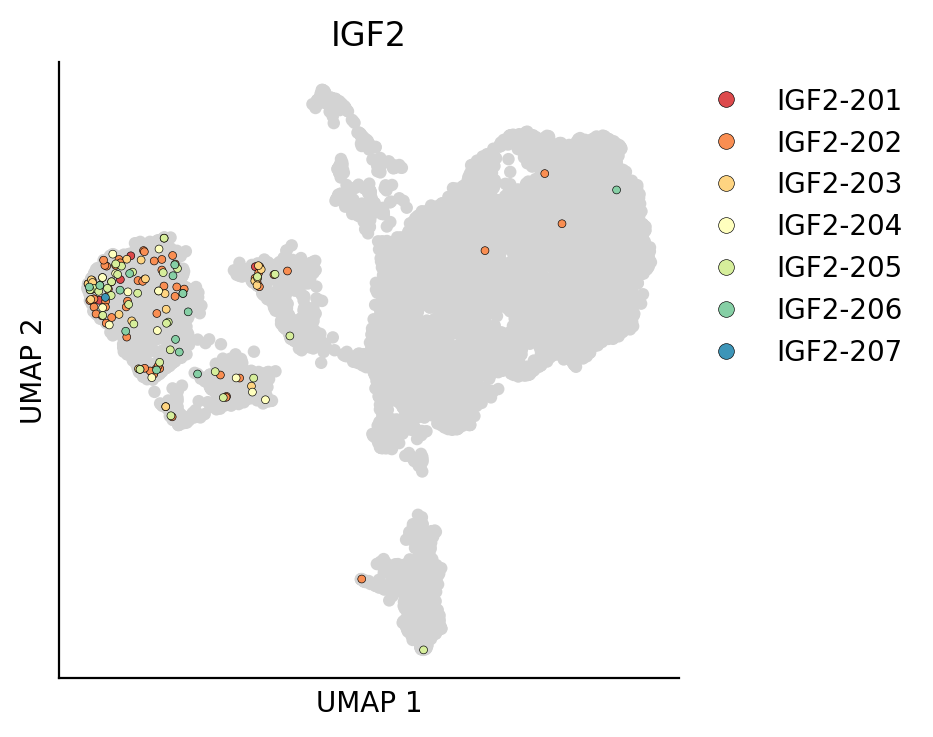

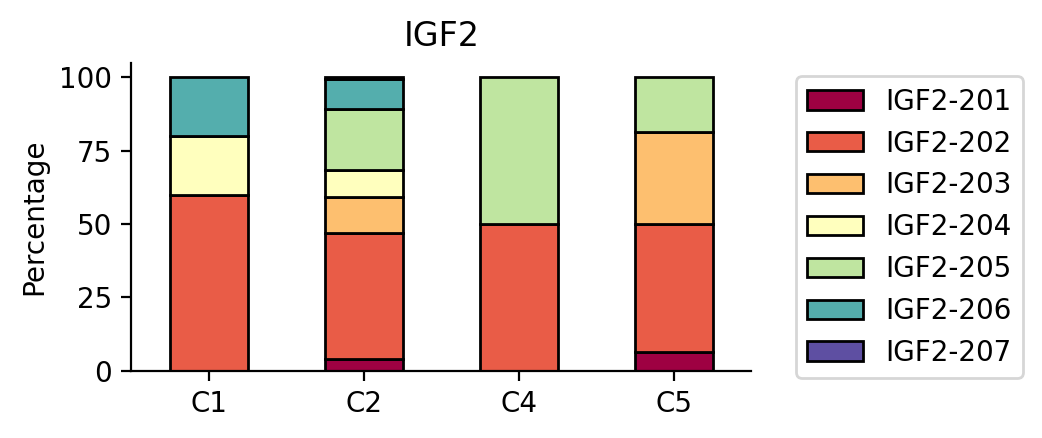

In [27]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

query = 'IGF2'

plot_isoform_umap(adata, df, query=query, size=20)
plt.show()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2
plot_cluster_expression(adata, df, query)
plt.show()

# Enrichments

In [ ]:
sort_by = 'C4'
# database = 'ontology'
# database = 'PanglaoDB_Augmented_2021'
database = 'Tabula_Sapiens'
database = 'TRRUST_Transcription_Factors_2019'
n_genes = 55
zdf = zdf.sort_values(by=sort_by, ascending=False)

query_genes = list(zdf.head(n_genes).index)
query_genes = [x.split("-")[0] for x in query_genes]

edf = gget.enrichr(
    query_genes, 
    database=database,
)

pd.set_option('display.max_colwidth', 150)
edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(10)

# zdf.head(20)

In [ ]:
break

In [ ]:
# def find_significant_transcripts(df, alpha=0.05):
#     """
#     Identifies transcript names whose values significantly differ by cluster using ANOVA.

#     Args:
#         df: DataFrame with columns 'transcript_name', 'cluster', and 'value'.
#         alpha: Significance level for the ANOVA test (default: 0.05).

#     Returns:
#         DataFrame: Table of results including transcript_name, F-statistic, and p-value.
#     """

#     def perform_anova(group):
#         """Performs ANOVA on a group of values."""
#         groups = [group[group['cluster'] == cluster]['value'] for cluster in df['cluster'].unique()]
#         # Check if there are enough groups for ANOVA (at least 2)
#         if len(groups) < 2:
#             return pd.Series({'F-statistic': np.nan, 'p-value': np.nan})
#         # Handle the case where a group might be empty
#         groups = [g for g in groups if not g.empty]
#         f_statistic, p_value = f_oneway(*groups)
#         return pd.Series({'F-statistic': f_statistic, 'p-value': p_value})

#     # Group by transcript_name and apply ANOVA
#     results_df = df.groupby('transcript_name').apply(perform_anova)

#     # Filter for statistically significant differences based on alpha
#     significant_transcripts = results_df[results_df['p-value'] < alpha]

#     return significant_transcripts


# test = proportions.copy().reset_index()
# test = test.drop(columns=['std'])
# test = pd.melt(
#     test,
#     id_vars='transcript_name'
# )

# res = find_significant_transcripts(test)
# res.head()

In [ ]:
break

In [ ]:
gene_list = [
    'LMBR1L', 'CHD2', 'UFL1', 'SRF', 'ACE', 'XRCC5', 'TAL1', 'ERCC2',
    'ZFP36', 'MLLT3', 'CDK6', 'MED1', 'SFRP1', 'SH2B3', 'GBA',
    'YJEFN3', 'SNAI2', 'ARIH2', 'WNT1', 'CD34', 'ETV6', 'WNT5A',
    'CEBPA', 'BRCA2', 'RUNX1', 'MECOM', 'SART3', 'SHB', 'NKAP',
    'WNT2B', 'SFRP2', 'BABAM1', 'YTHDF2', 'SEPTIN4', 'GATA2', 'CCN3',
    'ADAR', 'SOX4', 'ARHGEF5', 'FSTL1', 'UBAP2L', 'EMCN', 'OCIAD2',
    'NBEA', 'MYCT1', 'BAP1', 'GPRASP2', 'GLIS2', 'CRISPLD1', 'NLE1',
    'OCIAD1', 'ADGRG1',
]

for gene in gene_list:
    plot_isoform_umap(
        adata, 
        df, 
        query=gene, 
        size=20,
    )
    plt.show()
    


In [ ]:
query = 'CD59'

pdf = adata.obs.copy()
pdf = pdf.reset_index()

query_df = df[df['gene_name'] == query]

pdf = pd.merge(
    pdf, 
    query_df,
    how='left',
)

pdf = pdf.sort_values(by='transcript_name')


size = 15
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(
    data=pdf, 
    x='UMAP 1',
    y='UMAP 2',
    color='lightgrey',
    zorder=0,
    ec='none',
    s=size,
)

sns.scatterplot(
    data=pdf, 
    x='UMAP 1',
    y='UMAP 2',
    hue='transcript_name',
    ec='k',
    s= size / 2.5,
    # palette='viridis',
    palette='Spectral',
)

plt.xticks([])
plt.yticks([])

plt.ylabel('UMAP 2')
plt.xlabel('UMAP 1')

sns.despine()

plt.title(query)
plt.gca().set_aspect('auto')

sns.move_legend(
    plt.gca(),
    loc='upper right',
    title="",
    frameon=False,
    bbox_to_anchor=(1.6, 1),
    markerscale=2,
)

In [ ]:
break

In [ ]:
adata.obs.head()

# filter out the genes we care about

In [ ]:
gene_list = [
    'GATA2',
    'KIT',
    'MPL',
    'LMO2'
]

pdf = df[df['gene_name'].isin(gene_list)]
print(f"{pdf.shape=}")
pdf.head()

In [ ]:
break